# LDDMM: how to register a mesh against a template?

TODO: create a how to fully emulating Nicolas' script (i.e. including registration parameters)

In [11]:
from pathlib import Path

import herbrain.lddmm as lddmm
import pyvista as pv

from polpo.preprocessing import (
    DataPrinter,
    IfCondition,
    IndexSelector,
    Map,
    PartiallyInitializedStep,
    Sorter,
)
from polpo.preprocessing.dict import (
    DictKeysFilter,
    DictToTuplesList,
    HashWithIncoming,
)
from polpo.preprocessing.load import FigsharePregnancyDataLoader
from polpo.preprocessing.mesh.conversion import PvFromData
from polpo.preprocessing.mesh.filter import PvSelectColor
from polpo.preprocessing.mesh.io import PvWriter
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.preprocessing.mesh.smoothing import PvSmoothTaubin
from polpo.preprocessing.mesh.transform import MeshCenterer
from polpo.preprocessing.mri import (
    BRAINSTRUCT2COLOR,
    MeshExtractorFromSegmentedImage,
    MriImageLoader,
)
from polpo.preprocessing.path import FileFinder, FileRule, PathShortener
from polpo.preprocessing.str import DigitFinder

In [12]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Load meshes

We start by loading two selected meshes. 

In [13]:
source_index = 3
target_index = 25

struct_name = "PostHipp"
# struct_name = -1

In [14]:
# TODO: encode in file
reflected_keys = (
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
)

In [15]:
folders_selector = (
    (
        FigsharePregnancyDataLoader(
            data_dir="~/.herbrain/data/pregnancy",
            remote_path="Segmentations",
        )
        + FileFinder()
        + Sorter()
    )
    + HashWithIncoming(
        key_step=Map([PathShortener(), DigitFinder(index=0)]),
    )
    + DictKeysFilter(values=[source_index, target_index])
    + DictToTuplesList()
)

left_file_selector = FileFinder(
    rules=[
        FileRule(value="left", func="startswith"),
        FileRule(value=".nii.gz", func="endswith"),
    ]
)

right_file_selector = FileFinder(
    rules=[
        FileRule(value="right", func="startswith"),
        FileRule(value=".nii.gz", func="endswith"),
    ]
)

file_selector = IfCondition(
    step=IndexSelector(1) + DataPrinter() + left_file_selector,
    else_step=IndexSelector(1) + right_file_selector,
    condition=lambda datum: datum[0] not in reflected_keys,
)


mri2mesh = MriImageLoader() + MeshExtractorFromSegmentedImage() + PvFromData()

if struct_name == -1:
    struct_selector = lambda x: x

else:
    struct_selector = PvSelectColor(
        color=BRAINSTRUCT2COLOR[struct_name],
        extract_surface=True,
    )

pipe = folders_selector + Map(file_selector + mri2mesh + struct_selector)

In [16]:
meshes = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/Segmentations').


/home/luisfpereira/.herbrain/data/pregnancy/Segmentations/BB03


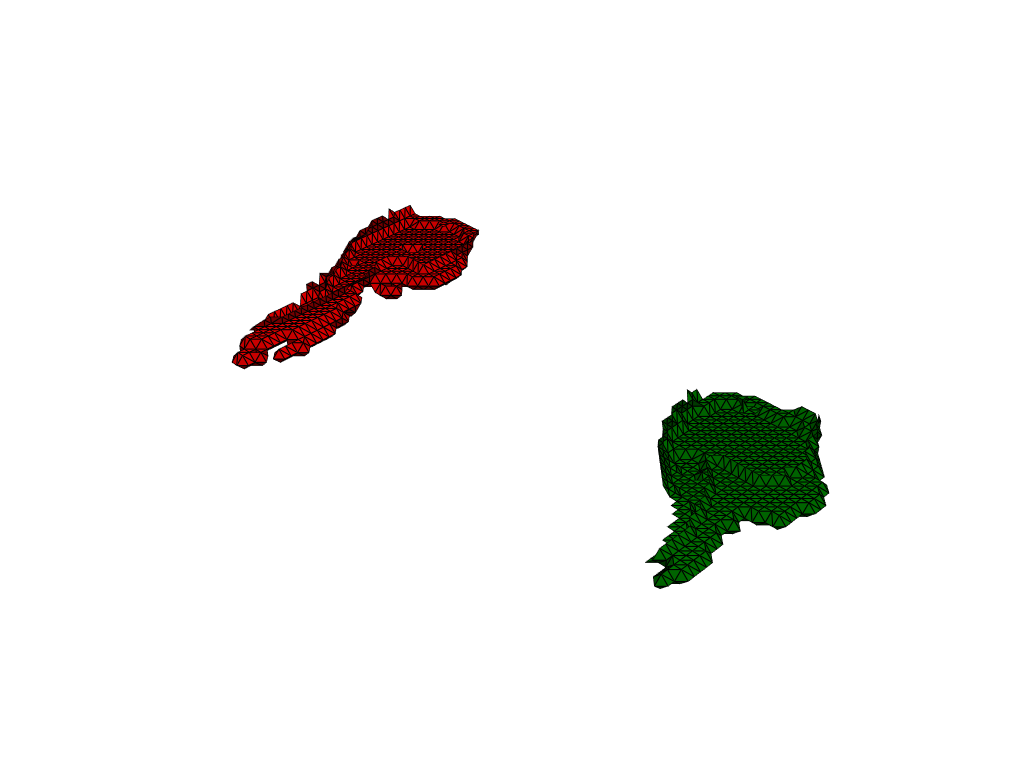

In [17]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## Preprocessing

As we can see in the visualization, meshes are not rigid aligned. Preprocessing takes care of this kind of details, before applying LDDMM.

In [18]:
# TODO: consider decimation if above a given number of points

prep_pipe = Map(MeshCenterer() + PvSmoothTaubin(n_iter=20)) + PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda x: x[0],
    max_iterations=10,
)

In [25]:
meshes = prep_pipe(meshes)

[mesh.points.shape[0] for mesh in meshes]

[666, 662]

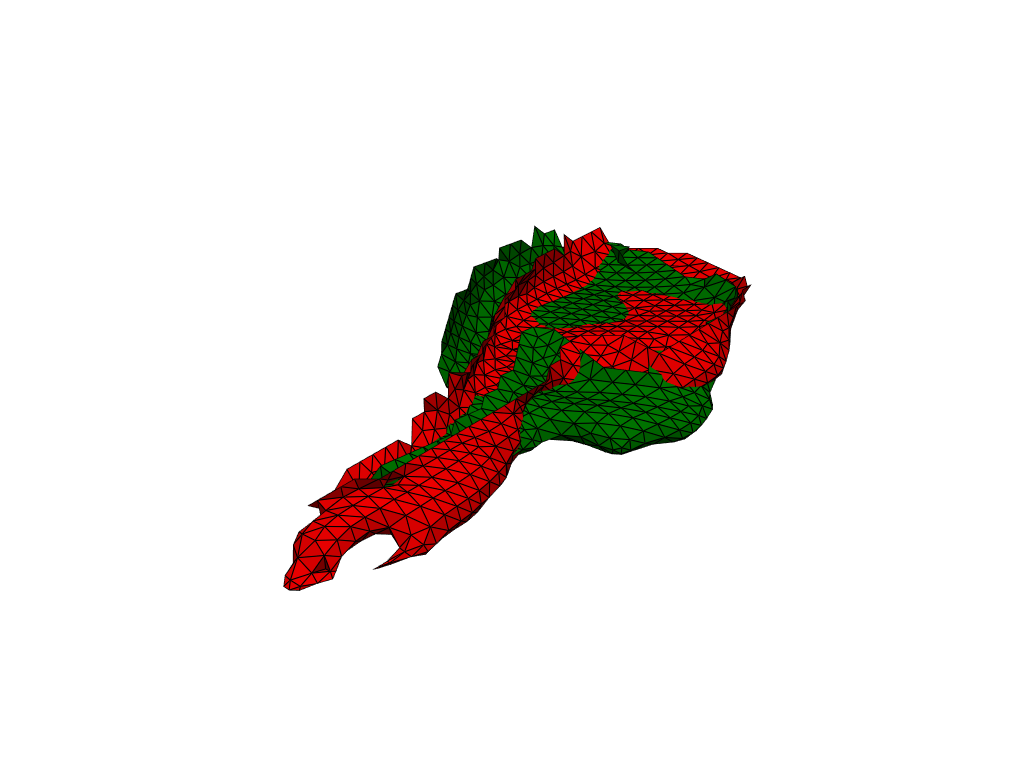

In [20]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## LDDMM

Create folder where to store the results.

In [21]:
registration_dir = Path("results")
initial_registration_dir = registration_dir / "initial_registration"

registration_dir.mkdir(exist_ok=True)  # TODO: make it to false

Save meshes in `vtk` format (as required by `deformetrica`).

In [22]:
meshes_writer = Map(PvWriter(dirname=registration_dir, ext="vtk"))

mesh_filenames = [f"mesh_{which}" for which in ["source", "target"]]
mesh_filenames = meshes_writer(list(zip(mesh_filenames, meshes)))

Use LDDMM to register the meshes.

In [23]:
# TODO: need to adapt registration parameters to substructure
lddmm.registration(
    mesh_filenames[0],
    mesh_filenames[1],
    output_dir=initial_registration_dir,
    kernel_width=4.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    attachment_kernel_width=2.0,
    metric="varifold",
    tol=1e-16,
    filter_cp=True,
    threshold=0.75,
)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/initial_registration/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 4.0 and gpu_mode GpuMode.KERNEL. addr: 0x72f1f3502550
instantiating kernel torch with kernel_width 2.0 and gpu_mode GpuMode.KERNEL. addr: 0x72f1e3423590
>> Set of 110 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

-------------

time.struct_time(tm_year=2025, tm_mon=3, tm_mday=17, tm_hour=21, tm_min=2, tm_sec=25, tm_wday=0, tm_yday=76, tm_isdst=0)